In [1]:
import sys, os, ndreg, skimage
import matplotlib.pyplot as plt
from matplotlib import cm
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import missing_data as mdmask
import ingest_tif_stack as ingest

In [2]:
import registerer_copy as reg
import preprocessor_copy as pre
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Load data

In [3]:
atlas_resolution = 50
atlas = ndreg.imgRead('./atlas/ara_atlas.img')
atlas_width, atlas_height, atlas_depth = atlas.GetSize()

rmt = BossRemote(cfg_file_or_dict='./intern.cfg')
annotations = ndreg.download_ara(rmt, 50, type='annotation')

full_img = ndreg.imgRead('./missing_insula/whole_insula.img')
orientation_atlas = 'pir'
orientation_image = 'lps'
full_img = ndreg.imgReorient(full_img, orientation_image, orientation_atlas)
full_img_width, full_img_height, full_img_depth = full_img.GetSize()

no_ant_missing_img = ndreg.imgRead('./missing_insula/missing_ant_insula_15.img')
no_ant_img_width, no_ant_img_height, no_ant_img_depth = no_ant_missing_img.GetSize()

half_missing_img = ndreg.imgRead('./missing_insula/half_insula.img')
half_missing_img = ndreg.imgReorient(half_missing_img, orientation_image, orientation_atlas)

# Create the missing image
missing_array = mdmask.gen_frac_mask(atlas_depth, atlas_height, atlas_width, 0.5, 0, side='left')
missing_mask = mdmask.convert_to_image(missing_array.astype('uint16'))
missing_mask.CopyInformation(atlas)
half_atlas = mdmask.mask_img(atlas, missing_mask)

# View of Atlas

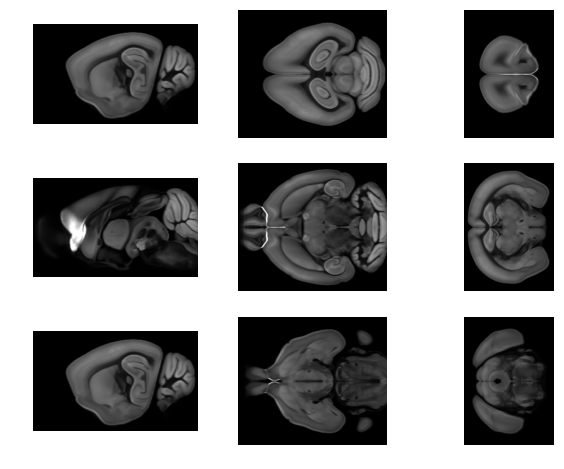

In [4]:
ndreg.imgShow(atlas)

# View of imaged brain

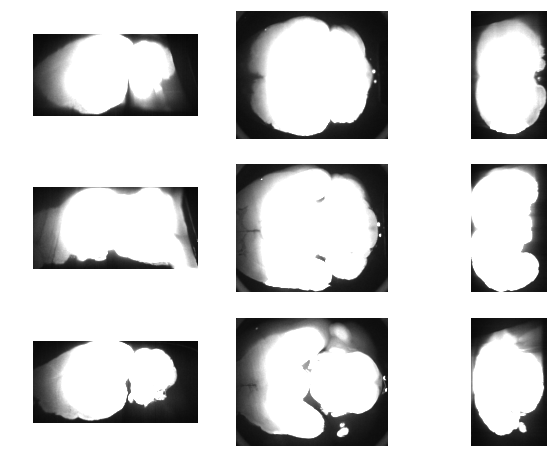

In [5]:
ndreg.imgShow(full_img,vmax=2000)

# Hemisphere of missing data

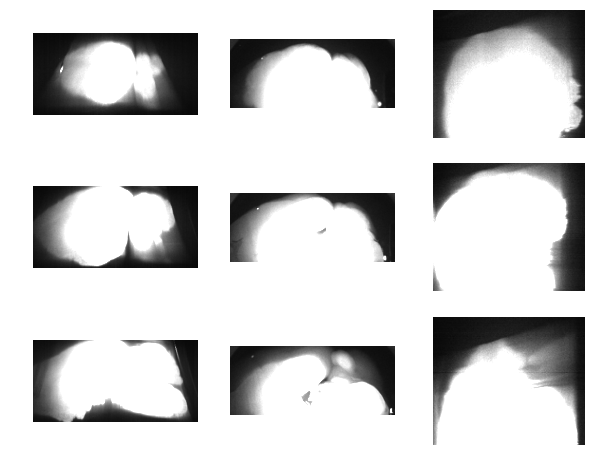

In [6]:
ndreg.imgShow(half_missing_img, vmax=2000)

# Brain with missing anterior 

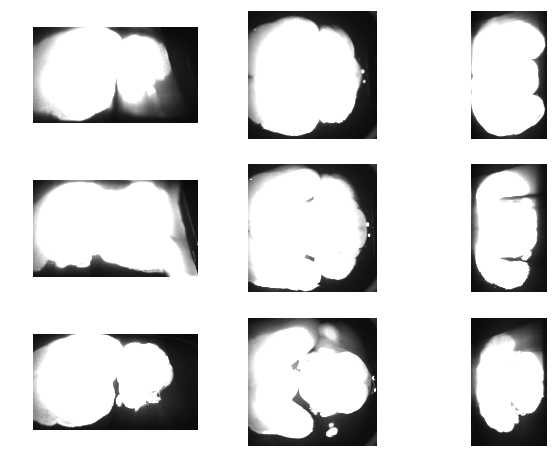

In [7]:
ndreg.imgShow(no_ant_missing_img, vmax=2000)

# Option 1: Pad image and create mask

## Padding example

In [8]:
padded_img, padded_mask = mdmask.pad_img_with_range(
    no_ant_missing_img, 
    width_range=(50,50),
    depth_range=(25,25),
    height_range=(30,30)
)

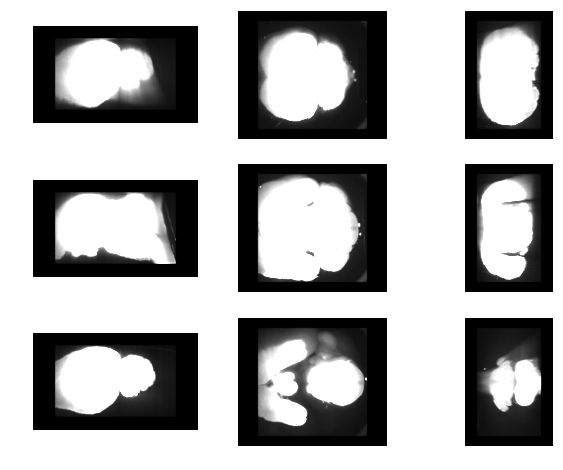

In [9]:
ndreg.imgShow(padded_img, vmax=2000)

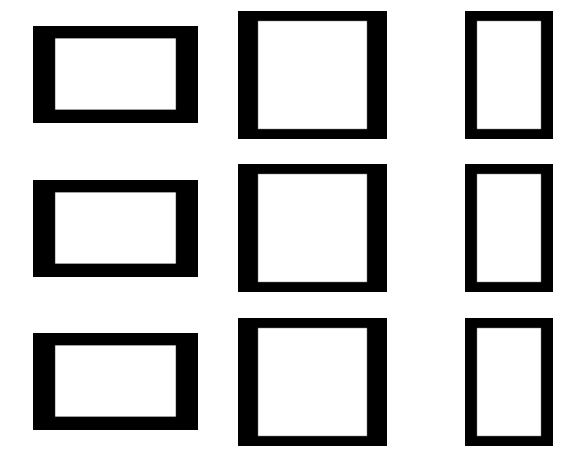

In [11]:
ndreg.imgShow(padded_mask)

## Padding image with partially missing anterior region

In [12]:
padded_img, padded_mask = mdmask.pad_img_with_range(
    no_ant_missing_img, 
    width_range=(abs(no_ant_img_width-full_img_width),0)
)

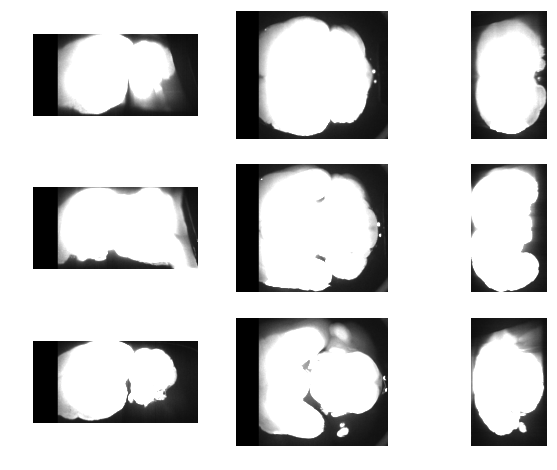

In [13]:
ndreg.imgShow(padded_img, vmax=2000)

# Option 2: Use a modified atlas

## Surgically remove parts of the atlas

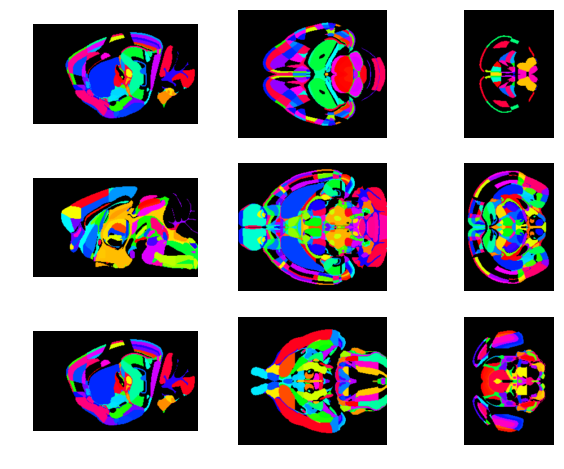

In [14]:
mdmask.plot_annotations(annotations)

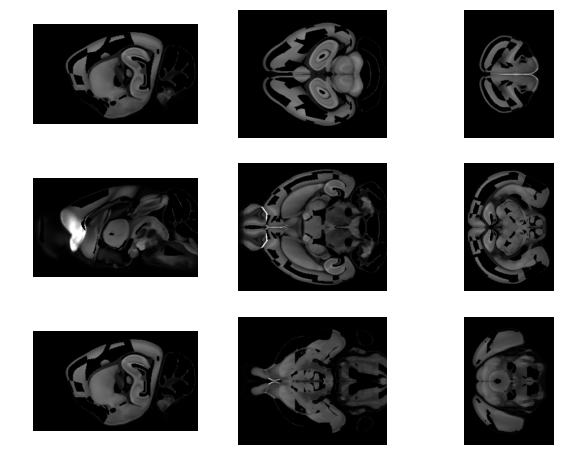

In [15]:
annotations_array = sitk.GetArrayFromImage(annotations)
clr_annotations_array = np.zeros((atlas_depth, atlas_height, atlas_width, 4))
missing_data_array = np.copy(sitk.GetArrayFromImage(atlas))
olfactory_bulb_layers = np.unique(annotations_array)[450:600]
for layer in olfactory_bulb_layers:
    missing_data_array[np.where(annotations_array == layer)] = 0
missing_data_mask = sitk.GetImageFromArray(missing_data_array)
ndreg.imgShow(missing_data_mask)

## Or you can make your own cuts like a half atlas

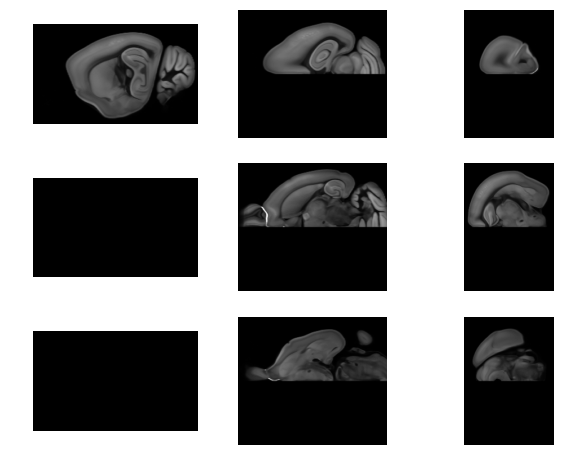

In [16]:
ndreg.imgShow(half_atlas)

# Demo of starting the registration...

## Skipping some preprocesing steps...
## Affine registration

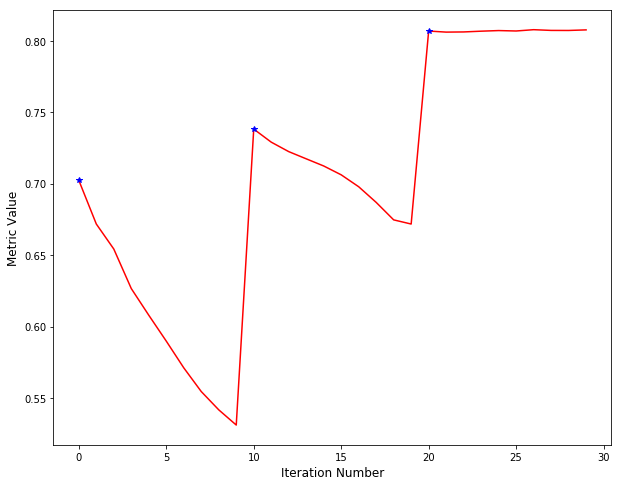

In [18]:
final_transform = reg.register_affine(sitk.Normalize(atlas),
                                    sitk.Normalize(padded_img),
                                    fixed_mask=padded_mask,
                                    learning_rate=1e-1,
                                    grad_tol=4e-6,
                                    use_mi=False,
                                    iters=10,
                                    shrink_factors=[4,2,1],
                                    sigmas=[0.4, 0.2, 0.1],
                                    verbose=True)

## Skipping some preprocessing steps
## LDDMM (Nonlinear registration)

In [ ]:
atlas_affine_with_mask = reg.resample(atlas, final_transform, padded_img, default_value=ndreg.imgPercentile(atlas,0.01))
e = 5e-3
s = 0.1
atlas_lddmm_with_mask, field, inv_field = reg.register_lddmm(affine_img=sitk.Normalize(atlas_affine_with_mask), 
                                                          target_img=sitk.Normalize(padded_img),
                                                          alpha_list=[0.05],
                                                          refMask=padded_mask,
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=e, sigma=s,
                                                          min_epsilon_list=e*1e-6,
                                                          use_mi=False, iterations=50, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	32197.9, 21.166, 0, 32176.7 (96.3515%), 5.500000e-03
1.	30924.4, 46.7738, 0, 30877.7 (92.4615%), 6.050000e-03
2.	29972.4, 100.124, 0, 29872.3 (89.4509%), 6.655000e-03
3.	29468.6, 173.877, 0, 29294.8 (87.7216%), 7.320500e-03
4.	29067.8, 270.155, 0, 28797.6 (86.233%), 8.052550e-03
5.	28743.8, 398.427, 0, 28345.4 (84.8786%), 8.857805e-03
6.	28656.2, 468.924, 0, 28187.2 (84.4052%), 4.871793e-03
7.	28403.7, 553.432, 0, 27850.3 (83.3962%), 5.358972e-03
8.	28081.7, 656.603, 0, 27425.1 (82.123%), 5.894869e-03
9.	27955.8, 714.828, 0, 27241 (81.5717%), 3.242178e-03
10.	27931.8, 747.054, 0, 27184.8 (81.4033%), 1.783198e-03
11.	27868.6, 783.028, 0, 27085.6 (81.1064%), 1.961518e-03
12.	27783.8, 822.487, 0, 26961.3 (80.7342%), 2.157670e-03
13.	27703, 866.982, 0, 26836 (80.359%), 2.373436e-03
14.	27657.7, 917.369, 0, 26740.3 (80.0725%), 2.610780e-03
15.	27644.6, 931.108, 0, 26713.5 (79.9921%), 7.